# Amazon Fine Food Reviews Analysis
The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

 Number of reviews: 568,454                                                                                                     
 Number of users: 256,059                                                                                                       
 Number of products: 74,258                                                                                                                                                                                                             
 Number of Attributes/Columns in data: 10
 
 Attributes:
1. IdRow Id
2. ProductIdUnique identifier for the product
3. UserIdUnqiue identifier for the user
4. ProfileNameProfile name of the user
5. HelpfulnessNumeratorNumber of users who found the review helpful
6. HelpfulnessDenominatorNumber of users who indicated whether they found the review helpful
7. ScoreRating between 1 and 5
8. TimeTimestamp for the review
9. SummaryBrief summary of the review
10. TextText of the review

Objective:

Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

t-SNE visualization of Amazon reviews with color-coding for positive and negitive reviews for BoW, tf-idf, Avg W2V, tf-idf W2V.

In [23]:
import warnings
warnings.filterwarnings("ignore")

# Loading the data using sqlite DataSet

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
import nltk
import string
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics 
from sklearn.metrics import roc_curve,auc
from nltk.stem.porter import PorterStemmer


con = sqlite3.connect('./AmazonFFR/database.sqlite')

# not taking into consideration those reviews with Score=3 as we need only positive and negative reviews
filtered_data = pd.read_sql_query("""
SELECT * FROM Reviews
WHERE Score !=3""",con)

In [3]:
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score greater than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative


In [4]:
filtered_data.shape #looking at the number of attributes and size of the data

(525814, 10)

In [5]:
filtered_data_pos = filtered_data[filtered_data.Score == 'positive']

filtered_data_pos=filtered_data_pos[0:2000]

filtered_data_pos['Score'].value_counts()

positive    2000
Name: Score, dtype: int64

In [6]:
filtered_data_neg = filtered_data[filtered_data.Score == 'negative']

filtered_data_neg=filtered_data_neg[0:2000]

filtered_data_neg['Score'].value_counts()

negative    2000
Name: Score, dtype: int64

In [7]:
#Slicing the filetered data to cut down number of rows to 2k each for +ve and -ve reviews because of memory issue.

filtered_data_final = pd.concat([filtered_data_pos,filtered_data_neg])
filtered_data_final['Score'].value_counts()

negative    2000
positive    2000
Name: Score, dtype: int64

In [8]:
# Data Cleaning :Duplication

sort_data = filtered_data_final.sort_values('ProductId',axis =0,ascending=True)

final = sort_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep='first',inplace=False)

final = final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [9]:
final.shape #rows are reduced to 46071 after removing duplicates

(3893, 10)

In [10]:
#Checking the counts of postive and negative reviews

final['Score'].value_counts()

positive    1997
negative    1896
Name: Score, dtype: int64

# 7.2.3 Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)
8. After which we collect the words used to describe positive and negative reviews

In [11]:
# find sentences containing HTML tags
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

8
I bought this dog food because the bag showed pictured of veggies and chunks of meat, and with a name like "Beneful" I thought I was purchasing a nutritious brand of dog food. My dogs did eat this food, but after reading the ingredients I completely regret purchasing it and feel just awful for feeding it to my dogs. The first three ingredients are Ground yellow corn, chicken by-product meal, and corn gluten meal. How disgusting is that?! The main ingredient is a corn filler. One thing my vet told me a while back that I never forgot: "When you eat corn, what comes out of the other end? The same thing happens with dogs." Basically, dogs cannot digest corn, it is just a filler and causes them to actually eat more to feel full, poop out more, and retain less nutrients. The only meat in Beneful at all is a by-product, its not even a real meat! By-products are the stuff leftover once all the actual meat is harvested. We're talking beaks, chicken feet, eyeballs, even chicken poop! I would n

In [12]:
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [13]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [14]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

In [15]:
final.head(3) #below the processed review can be seen in the CleanedText Column 

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,positive,961718400,Great Product,This was a really good idea and the final prod...,realli good idea final product outstand use de...
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,positive,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,receiv shipment could hard wait tri product lo...
1071,1161,B000084E1U,A3DH85EYHW4AQH,Eric Hochman,1,1,positive,1140739200,Cats love it!,I have nine cats and they are crazy about thes...,nine cat crazi kibbl last thing want cat food ...


In [16]:
# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

# Bag of Words (BoW)

In [17]:
count_vec = CountVectorizer(ngram_range=(1,2))  

final_counts = count_vec.fit_transform(final['CleanedText'].values)

In [18]:
final_counts.shape

(3893, 106488)

In [19]:
type(final_counts)

scipy.sparse.csr.csr_matrix

In [20]:
# score for the records
score_9564 = final["Score"]

In [26]:
 #Data Preprocessing: Standardizing the data
from sklearn.preprocessing import StandardScaler

std_data = StandardScaler(with_mean = False).fit_transform(final_counts)
std_data.shape

(3893, 106488)

In [27]:
# convert sparse to array as tsne throwed an error saying it needs dense vector.
std_data = std_data.toarray()

# TSNE for Bow with perplexity 5,30,50

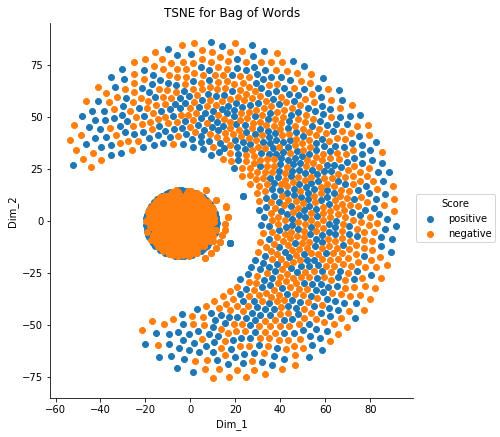

In [25]:
from sklearn.manifold import TSNE

model = TSNE(n_components=2,perplexity = 5,random_state=0)

#perplexity = 5
#default learning rate = 200

tsne_data = model.fit_transform(std_data)

tsne_data = np.vstack((tsne_data.T,score_9564)).T

tsne_df = pd.DataFrame(data = tsne_data,columns = ("Dim_1","Dim_2","Score"))

sns.FacetGrid(tsne_df,hue='Score',size=6) \
   .map(plt.scatter,'Dim_1','Dim_2').add_legend()

plt.title("TSNE for Bag of Words")
plt.show()

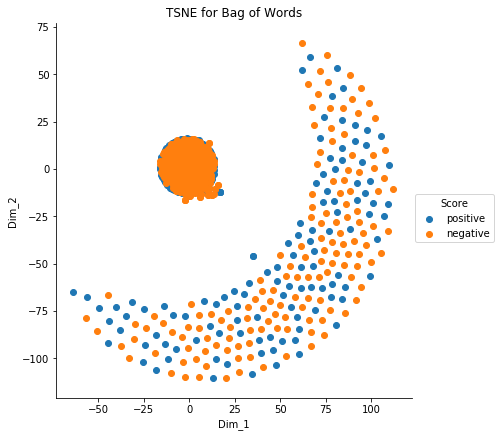

In [26]:
model = TSNE(n_components=2,perplexity = 30,random_state=0)

#perplexity = 30
#default learning rate = 200

tsne_data = model.fit_transform(std_data)

tsne_data = np.vstack((tsne_data.T,score_9564)).T

tsne_df = pd.DataFrame(data = tsne_data,columns = ("Dim_1","Dim_2","Score"))

sns.FacetGrid(tsne_df,hue='Score',size=6) \
   .map(plt.scatter,'Dim_1','Dim_2').add_legend()

plt.title("TSNE for Bag of Words")
plt.show()

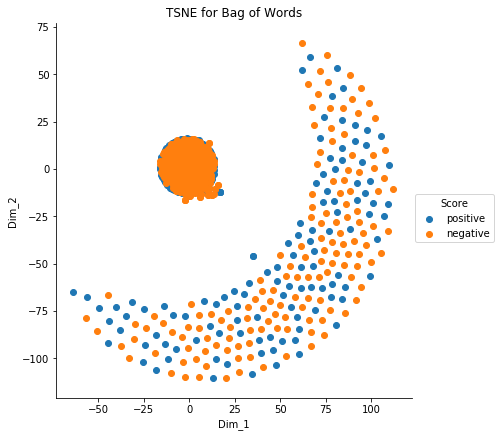

In [47]:
from sklearn.manifold import TSNE

model = TSNE(n_components=2,random_state=0)

#default perplexity = 30
#default learning rate = 200

tsne_data = model.fit_transform(std_data)

tsne_data = np.vstack((tsne_data.T,score_9564)).T

tsne_df = pd.DataFrame(data = tsne_data,columns = ("Dim_1","Dim_2","Score"))

sns.FacetGrid(tsne_df,hue='Score',size=6) \
   .map(plt.scatter,'Dim_1','Dim_2').add_legend()

plt.title("TSNE for Bag of Words")
plt.show()

Observations from tSNE using BoW: All +ve and -ve reviews are not well seperated for perplexity = 5, 30, 50.

# TF-IDF

In [56]:
tf_idf_vec = TfidfVectorizer(ngram_range=(1,2))

final_tf_idf = tf_idf_vec.fit_transform(final['CleanedText'].values)

final_tf_idf.shape

(3893, 106488)

In [29]:
# Standardization 
std_data_tfidf = StandardScaler(with_mean = False).fit_transform(final_tf_idf)

In [30]:
# convert sparse to array as tsne throwed an error saying it needs dense vector.
std_data_tfidf = std_data_tfidf.toarray()

# TSNE for TF-IDF with perplexity 5,30,50

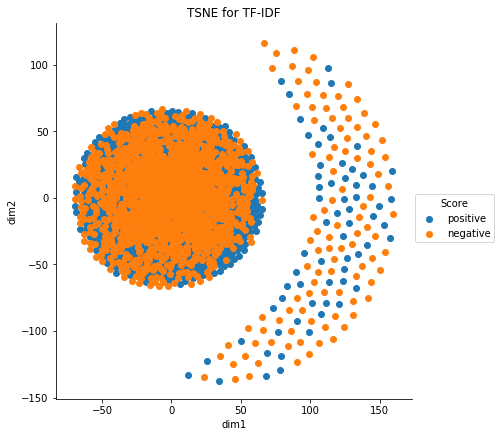

In [44]:
model = TSNE(n_components = 2, perplexity = 5, random_state =0)
tsne_data = model.fit_transform(std_data_tfidf)

tsne_data = np.vstack((tsne_data.T, score_9564)).T

tsne_df = pd.DataFrame(data = tsne_data, columns = ("dim1", "dim2", "Score"))

sns.FacetGrid(tsne_df, hue = "Score", size = 6).map(plt.scatter, "dim1", "dim2").add_legend()

plt.title("TSNE for TF-IDF")
plt.show()

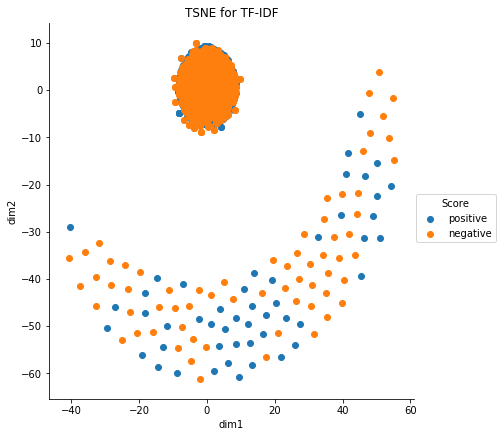

In [45]:
model = TSNE(n_components = 2, perplexity = 30, random_state =0)
tsne_data = model.fit_transform(std_data_tfidf)

tsne_data = np.vstack((tsne_data.T, score_9564)).T

tsne_df = pd.DataFrame(data = tsne_data, columns = ("dim1", "dim2", "Score"))

sns.FacetGrid(tsne_df, hue = "Score", size = 6).map(plt.scatter, "dim1", "dim2").add_legend()

plt.title("TSNE for TF-IDF")
plt.show()

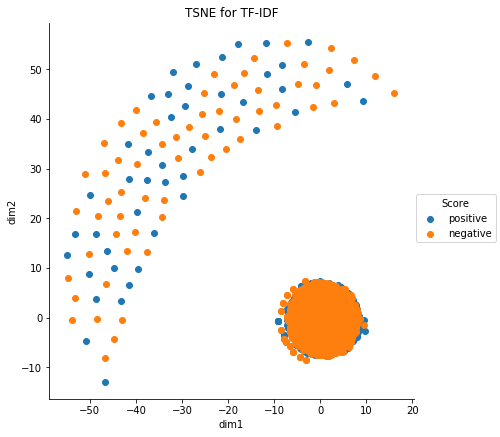

In [52]:
model = TSNE(n_components = 2, perplexity = 50)
tsne_data = model.fit_transform(std_data_tfidf)

tsne_data = np.vstack((tsne_data.T, score_9564)).T

tsne_df = pd.DataFrame(data = tsne_data, columns = ("dim1", "dim2", "Score"))

sns.FacetGrid(tsne_df, hue = "Score", size = 6).map(plt.scatter, "dim1", "dim2").add_legend()

plt.title("TSNE for TF-IDF")
plt.show()

Observations from tSNE using tf-idf: All +ve and -ve reviews are not well seperated for perplexity = 5, 30, 50.

# Word2Vec

In [24]:
# Using Google News Word2Vectors
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

In [25]:
import gensim
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent=[]
for sent in final['CleanedText'].values:
    list_of_sent.append(sent.split())

In [26]:
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)    

In [27]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  2766
sample words  ['realli', 'good', 'idea', 'final', 'product', 'outstand', 'use', 'car', 'window', 'everybodi', 'ask', 'bought', 'made', 'two', 'thumb', 'receiv', 'shipment', 'could', 'hard', 'wait', 'tri', 'love', 'call', 'instead', 'sticker', 'remov', 'easili', 'daughter', 'design', 'sign', 'print', 'beauti', 'shop', 'program', 'go', 'lot', 'fun', 'everywher', 'surfac', 'like', 'comput', 'monitor', 'cat', 'crazi', 'kibbl', 'last', 'thing', 'want', 'food', 'hate']


# Average Word2Vec

In [28]:
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

3893
50


# TSNE for Avg W2V with perplexity 5,30,50

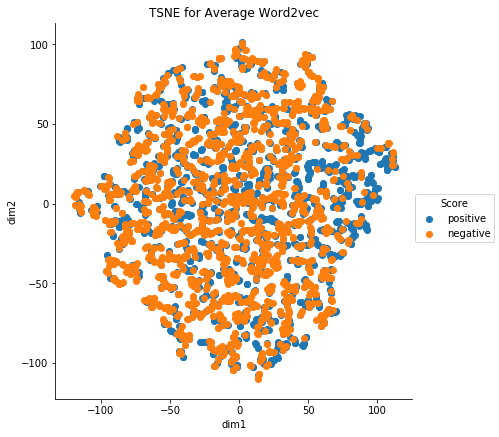

In [37]:
from sklearn.manifold import TSNE

model = TSNE(n_components = 2, perplexity = 5, random_state = 0) #perplexity = 5
tsne_data = model.fit_transform(sent_vectors)

tsne_data = np.vstack((tsne_data.T, score_9564)).T

tsne_df = pd.DataFrame(data = tsne_data, columns = ("dim1", "dim2", "Score"))

sns.FacetGrid(tsne_df, hue = "Score", size = 6).map(plt.scatter, "dim1", "dim2").add_legend()

plt.title("TSNE for Average Word2vec")
plt.show()

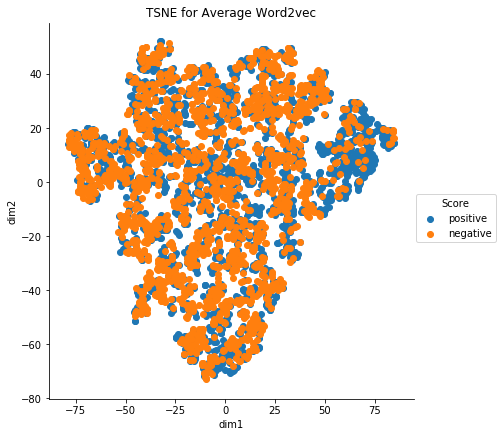

In [38]:
model = TSNE(n_components = 2, perplexity = 30, random_state =0) #perplexity = 30
tsne_data = model.fit_transform(sent_vectors)

tsne_data = np.vstack((tsne_data.T, score_9564)).T

tsne_df = pd.DataFrame(data = tsne_data, columns = ("dim1", "dim2", "Score"))

sns.FacetGrid(tsne_df, hue = "Score", size = 6).map(plt.scatter, "dim1", "dim2").add_legend()

plt.title("TSNE for Average Word2vec")
plt.show()

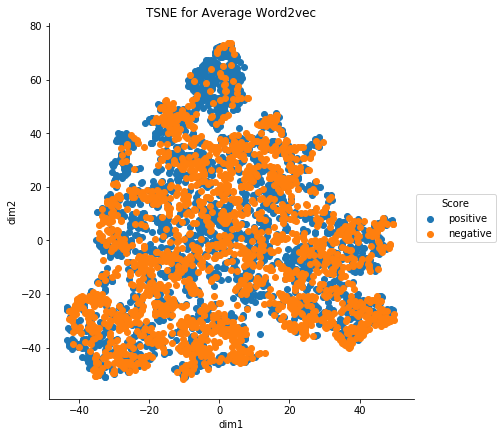

In [58]:
model = TSNE(n_components = 2, perplexity = 50)
tsne_data = model.fit_transform(sent_vectors)

tsne_data = np.vstack((tsne_data.T, score_9564)).T

tsne_df = pd.DataFrame(data = tsne_data, columns = ("dim1", "dim2", "Score"))

sns.FacetGrid(tsne_df, hue = "Score", size = 6).map(plt.scatter, "dim1", "dim2").add_legend()

plt.title("TSNE for Average Word2vec")
plt.show()

# 3-D tSNE plot for Avg W2V

In [29]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

from sklearn.manifold import TSNE

model = TSNE(n_components = 3, perplexity = 50,random_state =0)
tsne_data = model.fit_transform(sent_vectors)

tsne_data = np.vstack((tsne_data.T, score_9564)).T

In [42]:
tsne_data_pos = np.empty((0,4), float)

tsne_data_neg = np.empty((0,4), float)

for score in tsne_data:
    if score[3] == 'positive':
        tsne_data_pos = np.vstack((tsne_data_pos,score ))
    else:
        tsne_data_neg = np.vstack((tsne_data_neg,score ))
        

In [47]:
tsne_data_neg.shape

(1896, 4)

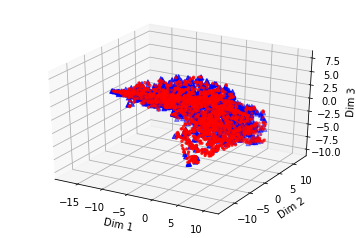

In [54]:
tsne_data_pos_x = tsne_data_pos[:,0]
tsne_data_pos_y = tsne_data_pos[:,1]
tsne_data_pos_z = tsne_data_pos[:,2]

tsne_data_neg_x = tsne_data_neg[:,0]
tsne_data_neg_y = tsne_data_neg[:,1]
tsne_data_neg_z = tsne_data_neg[:,2]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(tsne_data_pos_x, tsne_data_pos_y, tsne_data_pos_z, c = 'r', marker='.')

ax.scatter(tsne_data_neg_x, tsne_data_neg_y, tsne_data_neg_z, c = 'b', marker='^')

ax.set_xlabel('Dim 1')
ax.set_ylabel('Dim 2')
ax.set_zlabel('Dim 3')

plt.show()

Observations from tSNE using Avg W2V: All +ve and -ve reviews are not well seperated for perplexity = 5, 30, 50.

# TF-IDF weighted Word2Vec

In [57]:
tfidf_feat = tf_idf_vec.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

# TSNE for tf-idf W2V with perplexity 5,30,50

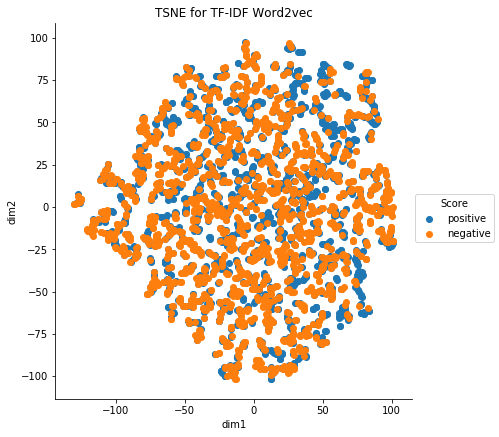

In [42]:
from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0, perplexity = 5) #perplexity = 5

tsne_data = model.fit_transform(tfidf_sent_vectors)

tsne_data = np.vstack((tsne_data.T, score_9564)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "Score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="Score", size=6).map(plt.scatter, 'dim1', 'dim2').add_legend()

plt.title("TSNE for TF-IDF Word2vec")
plt.show()

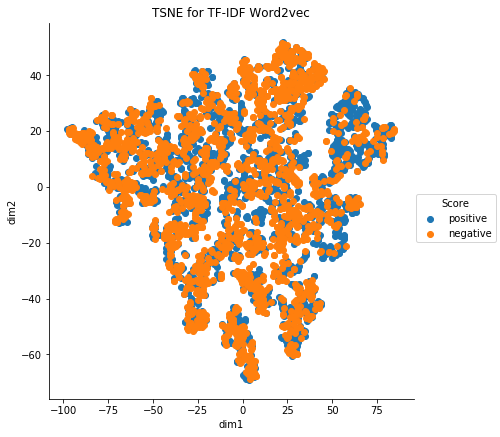

In [43]:
model = TSNE(n_components=2, random_state=0, perplexity = 30) #perplexity = 30

tsne_data = model.fit_transform(tfidf_sent_vectors)

tsne_data = np.vstack((tsne_data.T, score_9564)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "Score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="Score", size=6).map(plt.scatter, 'dim1', 'dim2').add_legend()

plt.title("TSNE for TF-IDF Word2vec")
plt.show()

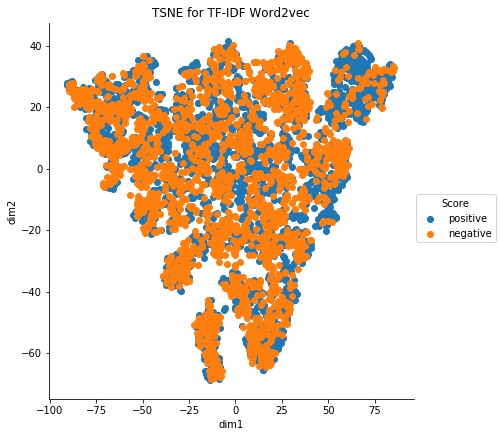

In [60]:
model = TSNE(n_components=2, random_state=0, perplexity = 50, n_iter = 5000)

tsne_data = model.fit_transform(tfidf_sent_vectors)

tsne_data = np.vstack((tsne_data.T, score_9564)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "Score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="Score", size=6).map(plt.scatter, 'dim1', 'dim2').add_legend()

plt.title("TSNE for TF-IDF Word2vec")
plt.show()

# 3-D tSNE plot for tf-idf W2V

In [58]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

from sklearn.manifold import TSNE

model = TSNE(n_components = 3, perplexity = 50,random_state =0)
tsne_data = model.fit_transform(tfidf_sent_vectors)

tsne_data = np.vstack((tsne_data.T, score_9564)).T

In [59]:
tsne_data_pos = np.empty((0,4), float)

tsne_data_neg = np.empty((0,4), float)

for score in tsne_data:
    if score[3] == 'positive':
        tsne_data_pos = np.vstack((tsne_data_pos,score ))
    else:
        tsne_data_neg = np.vstack((tsne_data_neg,score ))

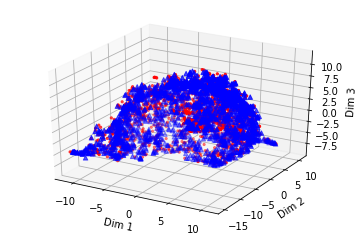

In [60]:
tsne_data_pos_x = tsne_data_pos[:,0]
tsne_data_pos_y = tsne_data_pos[:,1]
tsne_data_pos_z = tsne_data_pos[:,2]

tsne_data_neg_x = tsne_data_neg[:,0]
tsne_data_neg_y = tsne_data_neg[:,1]
tsne_data_neg_z = tsne_data_neg[:,2]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(tsne_data_pos_x, tsne_data_pos_y, tsne_data_pos_z, c = 'r', marker='.')

ax.scatter(tsne_data_neg_x, tsne_data_neg_y, tsne_data_neg_z, c = 'b', marker='^')

ax.set_xlabel('Dim 1')
ax.set_ylabel('Dim 2')
ax.set_zlabel('Dim 3')

plt.show()

Observations from tSNE using TFIDF-W2V: All +ve and -ve reviews are not well seperated for perplexity = 5, 30, 50.